In [53]:
# imporing required Liberaries
import matplotlib
import scipy.stats
import scipy.linalg
import scipy.sparse.linalg
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy.random as rnd
import scipy.linalg as LA
from scipy.integrate import ode


In [56]:
# Krotov Class to obatain Quantum CNOT gates
class Krotov:
    def __init__(self,J,lambda_1,ti,tf,steps):
        self.J = float(J)
        self.lambda_1 = float(lambda_1)
        self.ti = ti
        self.tf = tf
        self.steps = steps

        self.dt = (self.tf - self.ti) /self.steps
        self.sX = np.array([[0, 1], [1, 0]], dtype = 'complex')
        self.sY = np.array([[0, -1j], [1j, 0]], dtype = 'complex')
        self.sZ = np.array([[1, 0], [0, -1]], dtype = 'complex')
        self.I = np.array(np.identity(2), dtype = 'complex')

        self.sZZ = np.kron(self.sZ, self.sZ)
        self.sIY = np.kron(self.I, self.sY)
        self.sYI = np.kron(self.sY, self.I)
        self.sIZ = np.kron(self.I, self.sZ)
        self.sZI = np.kron(self.sZ, self.I)

        self.delta1 = 1
        self.alpha1 = 0.1
        self.delta2 = 0.1
        self.alpha2 = 0.01

        rnd.seed(1)

        # Controls
        self.EYI = rnd.rand(self.steps)-0.5
        #self.EYI_tilde = self.EYI
        self.EYI_tilde = np.zeros((self.steps,))
        self.EIY = rnd.rand(self.steps)-0.5
        #self.EIY_tilde = self.EIY
        self.EIY_tilde = np.zeros((self.steps,))
        self.EZI = rnd.rand(self.steps)-0.5

        self.Ui = np.identity(4, dtype = 'complex')
        self.UT = np.exp(1j * np.pi/4)*np.array([[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 0, 1],[0, 0, 1, 0]], dtype = 'complex')

        self.U = np.zeros([self.steps, 4, 4], dtype = 'complex')
        self.B = np.zeros([self.steps, 4, 4], dtype = 'complex')

        self.U[0] = np.identity(4, dtype = 'complex')
        self.B[steps - 1] = self.UT

        self. Ho = self.J/4 * self.sZZ + 100 * self.sIZ + 120 * self.sIZ

    def Hc(self, t_index):
        t = t_index
        return ( self.EIY[t] * self.sIY )

    def Hc_tilde(self, t_index):
        t = t_index
        return (self.EIY_tilde[t] * self.sIY)

    def H(self, t_index):
        t = t_index
        return (self.Ho + self.Hc(t))

    def H_tilde(self, t_index):
        t = t_index
        return (self. Ho + self.Hc_tilde(t))

    def update_U (self, t_index):
        t = t_index
        self.U[t+1] = np.dot(LA.expm(-1j * self.H(t) * self.dt), self.U[t])

    def update_B (self, t_index):
        t = t_index
        self.B[t-1] = np.dot( self.B[t], LA.expm(-1j * self.H_tilde(t) * self.dt))

    def update_E(self, t_index):
        t=t_index

        EIYpart1 = (1-self.delta2) * self.EIY_tilde[t-1]
        EIYpart2 = -self.delta2 * self.lambda_1 * np.imag( np.trace(np.dot(self.B[t-1], np.dot( self.sIY, self.U[t]) ) ) )/ self.alpha2
        self.EIY[t] = -(EIYpart1 + EIYpart2)


    def update_E_tilde(self,t_index):
        t = t_index
        EIYpart1 = (1-self.delta2) * self.EIY[t]
        EIYpart2 = -self.delta2 * self.lambda_1 * np.imag( np.trace(np.dot(self.B[t], np.dot( self.sIY, self.U[t]) ) ) )/ self.alpha2
        self.EIY_tilde[t] = -(EIYpart1 + EIYpart2)

    def evolution_U(self,string='not initial'):
        if string == 'initial':
            for t in range(0,self.steps-1):
                self.update_U(t)
        else:
            for t in range(0,self.steps-1):
                self.update_E(t)
                self.update_U(t)
            t = self.steps-1
            self.update_E(t)

    def evolution_B(self):
        for t in range(self.steps-1,0,-1):
            self.update_E_tilde(t)
            self.update_B(t)
        t = 0
        self.update_E_tilde(t)

    def O(self,step):
        t = step
        return( np.dot(self.UT.conj().T, self.U[t - 1] ))
        # Returns <<PSI|O|PSI>>>
    def Overlap(self, t_index ):
        t = t_index
        return( np.abs(np.trace(self.O(t))))

    def distance(self,t_index):
        t= t_index
        return(LA.norm(self.UT - self.U[t-1], 'fro'))

    def Run_Krotov(self, num_iter):
        T = self.steps-1
        self.evolution_U('initial')

        self.overlap = []
        self.dis = []

        for i in range(0,num_iter):
            print ("Iteration : ", i)
            self.B[T] = self.O(T-1)
            self.evolution_B()
            self.evolution_U()
            self.overlap.append(self.Overlap(T))
            self.dis.append(self.distance(T))

Iteration :  0
Iteration :  1
Iteration :  2
Iteration :  3
Iteration :  4
Iteration :  5
Iteration :  6
Iteration :  7
Iteration :  8
Iteration :  9
Iteration :  10
Iteration :  11
Iteration :  12
Iteration :  13
Iteration :  14
Iteration :  15
Iteration :  16
Iteration :  17
Iteration :  18
Iteration :  19


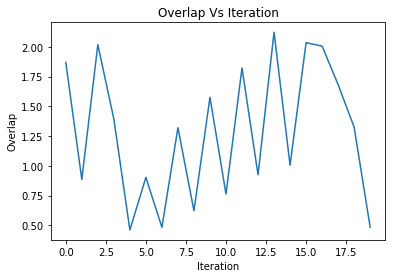

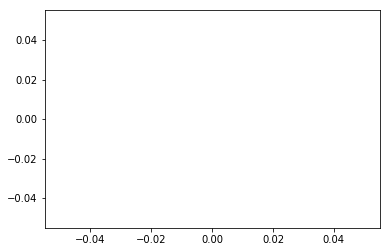

In [57]:
if __name__ == '__main__':
    # INTITIALIZE : J,lambda_1,ti,tf,steps

    k = Krotov(0.1, 1 ,0, 7,500)
    k.Run_Krotov(20)
    s = Krotov(0.1, 1 ,0, 7,500)
    s.Run_Krotov(0)

    plt.figure(1)
    plt.title('Overlap Vs Iteration')
    plt.ylabel('Overlap')
    plt.xlabel('Iteration')
    plt.plot(np.abs(k.overlap))
    plt.show()
    plt.figure(2)
    plt.plot(s.dis)
    plt.show()

In [52]:
s.dis

[]